In [65]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget
plt.close('all')
import numpy as np
from sklearn.preprocessing import StandardScaler
from random import choice
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

path_save = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\127_20220705\Analysis_127_20220705_100_Version1\time_plate_info.json"
time_plate_info = pd.read_json(path_save)
time_plate_info = time_plate_info.transpose()
path_save = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\127_20220705\Analysis_127_20220705_100_Version1\folder_info.json"
folders = pd.read_json(path_save)
folders = folders.reset_index()
plt.style.use('presentation.mplstyle')
time_plate_info = time_plate_info.fillna(-1)

In [34]:
time_plate_info['time_since_begin']=folders['datetime']-folders['datetime'].iloc[0]

In [37]:
time_plate_info['time_since_begin']

0    0 days 00:00:00
1    0 days 02:43:00
2    0 days 04:44:00
3    0 days 06:44:00
4    0 days 08:44:00
           ...      
95   9 days 06:30:00
96   9 days 08:30:00
97   9 days 10:30:00
98   9 days 12:30:00
99   9 days 14:30:00
Name: time_since_begin, Length: 100, dtype: timedelta64[ns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0
[ 2.2315699   8.28503962 11.50234144 13.9987798  16.11297034 17.98026113
 19.67108964 21.22766461 22.67764807 24.04033484 25.32981793 26.55676286
 27.72947225 28.85455958 29.93739443 30.98240731 31.99330461 32.97322425
 33.92485069 34.85050174] [ 2.44088018e+03  2.42357231e+02  1.23596319e+02  9.66918514e+01
  3.12743458e+02  7.12175872e+01  1.30353629e+00  3.61994862e+02
  1.33715211e+02 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
1
[ 2.2315699   8.28503962 11.50234144 13.9987798  16.11297034 17.98026113
 19.67108964 21.22766461 22.67764807 24.04033484 25.32981793 26.55676286
 27.72947225 28.85455958 29.93739443 30.98240731 31.99330461 32.97322425
 33.92485069 34.85050174] [ 3.25592430e+03  3.51917944e+03  2.61293384e+03  2.82870430e+02
  3.09153622e+02  7.48248476e+01  5.89316833e+00  3.71084972e+02
  1.68695701e+02 -1.00000000e+00 -1.00000000e+00 -

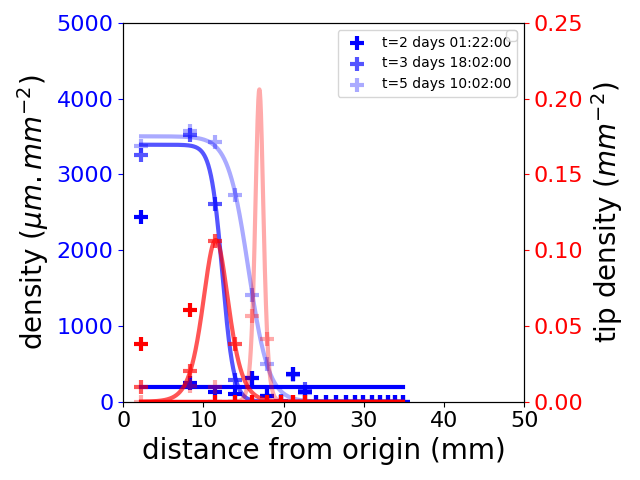

In [44]:
plate = 127
def S(t,lamb,C,t0):
    return(C*(1/(1+np.exp(lamb*(t0-t)))))
def dS(t,lamb,C,t0):
    return(C*((np.exp(lamb*(t0-t))/(1+np.exp(lamb*(t0-t)))**2)))
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
# table = table.fillna(-1)
ts = list(table.index)
ts.sort()
dic = {}
fig, ax = plt.subplots()
ax.axis([0,50,0,5000])
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('density ($\mu m.mm^{-2}$)') 
ax2=ax.twinx()
ax2.set_ylim((0,0.25))
ax2.set_ylabel('tip density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
timesteps = [20,40,60]
for i,t in enumerate(timesteps):
    print(i)
#     ax.set_yscale("log")

    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues) if y!=0])
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    print(X,Y)
    popt0, pcov = curve_fit(S, X,Y,bounds = ([-np.inf,0,-np.inf],[0,np.inf,np.inf]),p0=[-1,1,0])
    lamb,C,t0 = list(popt0)
    ax.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,
            marker = "+",color="blue",label=f't={table["time_since_begin"][t]}',
           alpha = (len(timesteps)-i)/len(timesteps))
    ts = np.linspace(np.min(X),np.max(X),1000)
    ax.plot(ts,S(ts,lamb,C,t0),alpha = (len(timesteps)-i)/len(timesteps),color='blue')
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)  
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    popt0, pcov = curve_fit(dS, X,Y,bounds = ([-np.inf,0,-np.inf],[0,np.inf,np.inf]),p0=[lamb,1,t0])
    lamb,C,t0 = list(popt0)
    ax2.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = "+",color="red",
           alpha = (len(timesteps)-i)/len(timesteps))
    ts = np.linspace(np.min(X),np.max(X),1000)
    ax2.plot(ts,dS(ts,lamb,C,t0),alpha = (len(timesteps)-i)/len(timesteps),color='red')

    right = 0.90
    top = 0.90
    fontsize = 10
#     text = ax.text(
#     right,
#     top,
#     f"plate {plate}; time = {int(table['time_since_begin'][t])}h",
#     horizontalalignment="right",
#     verticalalignment="bottom",
#     transform=ax.transAxes,
#     color="black",
#     fontsize = fontsize,
# )
ax.legend()
ax2.legend()
plt.tight_layout()

save = f'Figure/im{t}.svg'
plt.savefig(save)
# plt.close(fig)
#     break
# img_array = []
# for t in ts:
#     img = imageio.imread(f'Figure/im{t}.png')
#     img_array.append(img)
    
# path_movie = f'movies/{plate}_full.mp4'
# imageio.mimsave(path_movie, img_array)

In [45]:
plate =  127
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
# table = table.fillna(-1)
# table= table.set_index('t')
ts = list(table.index)
ts.sort()
dic = {}

for t in ts:
    fig, ax = plt.subplots()

#     ax.set_yscale("log")
    ax.axis([0,50,0,5000])
    ax.set_xlabel('distance from origin (mm)')
    ax.set_ylabel('density ($\mu m.mm^{-2}$)') 
    ax2=ax.twinx()
    ax2.set_ylim((0,0.25))
    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues) if y!=0])
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)         
    ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = "+",)
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)         
    ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = "+",color="red")
    ax2.set_ylabel('tip density ($mm^{-2}$)')
    ax.tick_params(axis='y', colors='blue')
    ax2.tick_params(axis='y', colors='red')
    right = 0.90
    top = 0.90
    fontsize = 10
    text = ax.text(
    right,
    top,
    f"plate {plate}; time = {table['time_since_begin'][t]}h",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    color="black",
    fontsize = fontsize,
)
    save = f'Figure/im{t}.png'
    ax.tick_params(axis='y', colors='blue')
    ax2.tick_params(axis='y', colors='red')
    plt.tight_layout()

    plt.savefig(save)
    plt.close(fig)
#     break
img_array = []
for t in ts:
    img = imageio.imread(f'Figure/im{t}.png')
    img_array.append(img)
    
path_movie = f'movies/{plate}_full.mp4'
imageio.mimsave(path_movie, img_array)

C:\Users\coren\AppData\Local\Temp\ipykernel_11688\3580284145.py:78: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(f'Figure/im{t}.png')


In [ ]:
time_plate_info.loc[time_plate_info["Plate"]==1053]

***Generation f(x-ct)***

In [46]:
time_plate_info['time_since_begin_h']=time_plate_info['time_since_begin'].apply(lambda x: x.value/(3600*1e9))
table = time_plate_info.loc[time_plate_info["Plate"]==127]


In [47]:
def wave(xt,c,lamb,K,x0):
    x=xt[0,:]
    t = xt[1,:]
    return(K*(1/(1+np.exp(lamb*(x0+x-c*t)))))

In [48]:
def dwave(xt,c,lamb,K,x0):
    x=xt[0,:]
    t = xt[1,:]
    return(K*(np.exp(lamb*(x0+x-c*t))/(1+np.exp(lamb*(x0+x-c*t)))**2))

In [49]:
def dS(t,lamb,C,t0):
    return(C*((np.exp(lamb*(t0-t))/(1+np.exp(lamb*(t0-t)))**2)))

In [56]:
tot_t = list(table.index)
tot_t.sort()
timesteps = tot_t[0:80]
# timesteps = [tot_t[0],tot_t[80]]

ts = []
xs = []
ys = []
for time in timesteps:
#     ax.set_yscale("log")
    
    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}"
        return(float(table[column][time]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    xvalues = list(xvalues)
    tvalues = [time for x in xvalues]
    ts+=tvalues
    xs += xvalues
    ys += yvalues
xt = np.array((xs,ts))
popt_f,cov = curve_fit(wave, xt,ys,bounds = ([0,0,0,-np.inf],[np.inf,np.inf,np.inf,np.inf]),p0=[0.2,-lamb,C,0])
popt_f,cov = curve_fit(wave, xt,ys,bounds = ([0,0,0,-np.inf],[np.inf,np.inf,np.inf,np.inf]),p0=[0.2]+list(popt_f[1:]))
# popt_f[0]/=1.5

popt_f

array([ 2.59886681e-01,  7.22936979e-01,  3.20374823e+03, -4.82371070e-01])

In [57]:
residuals = ys- wave(xt, *popt_f)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ys-np.mean(ys))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

0.93888278439897

In [58]:
tot_t = list(table.index)
tot_t.sort()
# timesteps = tot_t[0:80]
timesteps = [tot_t[40],tot_t[60]]

ts = []
xs = []
ys = []
for time in timesteps:
#     ax.set_yscale("log")
    
    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][time]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    xvalues = list(xvalues)
    tvalues = [time for x in xvalues]
    ts+=tvalues
    xs += xvalues
    ys += yvalues
xt = np.array((xs,ts))
ys = np.array(ys)
pos = np.where(ys>=0)[0]
xt = xt[:,pos]
ys = ys[pos]
# popt_f,cov = curve_fit(wave, xt,ys,bounds = ([0,0,0,-np.inf],[np.inf,np.inf,np.inf,np.inf]),p0=[0.2,-lamb,C,0])
popt_f2,cov = curve_fit(dwave, xt,ys,bounds = ([0,0,0,-np.inf],[np.inf,np.inf,np.inf,np.inf]),p0=[0.2,popt_f[1],popt_f[2]/3000,popt_f[3]])
popt_f2

array([ 0.25372107,  1.85673652,  0.44706514, -1.72833551])

In [59]:
residuals = ys- dwave(xt, *popt_f2)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ys-np.mean(ys))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

0.871889777600706

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


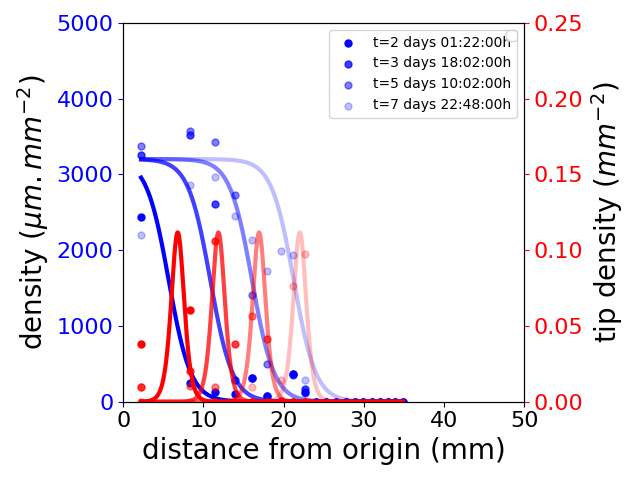

In [64]:
plate = 127
def S(t,lamb,C,t0):
    return(C*(1/(1+np.exp(lamb*(t0-t)))))
def dS(t,lamb,C,t0):
    return(C*((np.exp(lamb*(t0-t))/(1+np.exp(lamb*(t0-t)))**2)))
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
# table = table.fillna(-1)
# table= table.set_index('t')
ts = list(table.index)
ts.sort()
dic = {}
fig, ax = plt.subplots()
ax.axis([0,50,0,5000])
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('density ($\mu m.mm^{-2}$)') 
ax2=ax.twinx()
ax2.set_ylim((0,0.25))
ax2.set_ylabel('tip density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
timesteps = [20,40,60,80]
for i,t in enumerate(timesteps):
#     ax.set_yscale("log")

    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues) if y!=0])
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    ax.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,
            marker = ".",color="blue",label=f't={table["time_since_begin"][t]}h',
           alpha = (len(timesteps)-i)/len(timesteps))
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [t for x in xs]
    xt = np.array((xs,ts))
    ax.plot(xs,wave(xt,*popt_f),alpha = (len(timesteps)-i)/len(timesteps),color='blue')
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)  
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    ax2.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = ".",color="red",
           alpha = (len(timesteps)-i)/len(timesteps))
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [t for x in xs]
    xt = np.array((xs,ts))
    ax2.plot(xs,dwave(xt,*popt_f2),alpha = (len(timesteps)-i)/len(timesteps),color='red')

    right = 0.90
    top = 0.90
    fontsize = 10
#     text = ax.text(
#     right,
#     top,
#     f"plate {plate}; time = {int(table['time_since_begin'][t])}h",
#     horizontalalignment="right",
#     verticalalignment="bottom",
#     transform=ax.transAxes,
#     color="black",
#     fontsize = fontsize,
# )
ax.legend()
ax2.legend()
plt.tight_layout()

save = f'Figure/im{t}.svg'
plt.savefig(save)
# plt.close(fig)
#     break
# img_array = []
# for t in ts:
#     img = imageio.imread(f'Figure/im{t}.png')
#     img_array.append(img)
    
# path_movie = f'movies/{plate}_full.mp4'
# imageio.mimsave(path_movie, img_array)

In [35]:
xs = np.linspace(np.min(X),np.max(X),1000)
ts = [t for x in xs]
xt = np.array((xs,ts))
xt

array([[ 7.85362623,  7.88145513,  7.90928402, ..., 35.59903352,
        35.62686242, 35.65469131],
       [80.        , 80.        , 80.        , ..., 80.        ,
        80.        , 80.        ]])

In [18]:
popt0, pcov = curve_fit(dS, X,Y,bounds = ([-np.inf,0,-np.inf],[0,np.inf,np.inf]),p0=[lamb,0,t0])
lamb,C,t0 = list(popt0)


C:\Users\coren\anaconda3\envs\cleanMsc\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """


In [7]:
lamb,C,t0

(5.657337276353005, -2.1899599429301185e-13, 3.367725527943144)

In [10]:
import json
with open('data.json', 'w') as fp:
    json.dump(dic, fp)

In [6]:
plate = 152
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table = table.fillna(-1)
table= table.set_index('t')
timedelta = 2
for index in range(20):
    table[f'anas_density_index-{index}'] = np.cumsum(table[f"ring_anas_density_incr-100_index-{index}"])*timedelta
ts = list(table.index)
ts.sort()
for t in ts:
    fig, ax = plt.subplots()
#     ax.set_yscale("log")
    ax.axis([0,50,0,0.1])
    ax.set_xlabel('distance from origin (mm)')
    ax.set_ylabel(r'anas density ($mm^{-2}$)')
    ax2=ax.twinx()
    ax2.set_ylim((0,0.25))
    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f'anas_density_index-{index}'
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)         
    _ = ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = "+",)
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)         
    _ = ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = "+",color="red")
    ax2.set_ylabel('tip density ($mm^{-2}$)')

    right = 0.90
    top = 0.90
    fontsize = 10
    text = ax.text(
    right,
    top,
    f"plate {plate}; time = {int(table['time_since_begin'][t])}h",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    color="black",
    fontsize = fontsize,
)
    save = f'Figure/im{t}'
    _ = plt.savefig(save)
    plt.close(fig)
#     break
img_array = []
for t in ts:
    img = cv2.imread(f'Figure/im{t}.png')
    img_array.append(img)
    
path_movie = f'movies/{plate}_anas_dens.mp4'
imageio.mimsave(path_movie, img_array,fps=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
plate = 152
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table = table.fillna(-1)
table= table.set_index('t')
for index in range(20):
    table[f'branch_density_index-{index}'] = np.cumsum(table[f"ring_branch_density_incr-100_index-{index}"])*timedelta
ts = list(table.index)
ts.sort()
for t in ts:
    fig, ax = plt.subplots()
#     ax.set_yscale("log")
    ax.axis([0,50,0,0.2])
    ax.set_xlabel('distance from origin (mm)')
    ax.set_ylabel(r'new branch density ($mm^{-2}$)')
    ax2=ax.twinx()
    ax2.set_ylim((0,0.2))
    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f'branch_density_index-{index}'
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)         
    ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = "+",)
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)         
    ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = "+",color="red")
    ax2.set_ylabel('tip density ($mm^{-2}$)')

    right = 0.90
    top = 0.90
    fontsize = 10
    text = ax.text(
    right,
    top,
    f"plate {plate}; time = {int(table['time_since_begin'][t])}h",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    color="black",
    fontsize = fontsize,
)
    save = f'Figure/im{t}'
    plt.savefig(save)
    plt.close(fig)
#     break
img_array = []
for t in ts:
    img = cv2.imread(f'Figure/im{t}.png')
    img_array.append(img)
    
path_movie = f'movies/{plate}_branch_dens.mp4'
imageio.mimsave(path_movie, img_array,fps=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyError: 'branch_density_index-0'

In [17]:
plate = 94
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table = table.fillna(-1)
table= table.set_index('t')
ts = list(table.index)
ts.sort()
for t in ts:
    fig, ax = plt.subplots()
#     ax.set_yscale("log")
    ax.axis([0,50,0,1000])
    ax.set_xlabel('distance from origin (mm)')
    ax.set_ylabel(r'bas length density ($\mu m.mm^{-2}$)')
    ax2=ax.twinx(color='red')
    ax2.set_ylim((0,3000))
    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_bas_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)         
    ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = "+",color="black")
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)         
    ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = "+",color="red")
    ax2.set_ylabel('network density ($\mu m.mm^{-2}$)')

    right = 0.90
    top = 0.90
    fontsize = 10
    text = ax.text(
    right,
    top,
    f"plate {plate}; time = {int(table['time_since_begin'][t])}h",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    color="black",
    fontsize = fontsize,
)
    save = f'Figure/im{t}'
    plt.savefig(save)
    plt.close(fig)
#     break
img_array = []
for t in ts:
    img = cv2.imread(f'Figure/im{t}.png')
    img_array.append(img)
    
path_movie = f'movies/{plate}_bas_dens.mp4'
imageio.mimsave(path_movie, img_array,fps=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [104]:
plt.close('all')
plate = 94
table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
fig, ax = plt.subplots()
ts = []
ys = []
ys2 = []
ax2 = ax.twinx()

for index in range(20):
    column = f"ring_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    start = np.min(table.loc[table[column]>=1000]['time_since_begin'])
    if not np.isnan(start):
        table[f'time_since_begin_{index}']=table['time_since_begin']-start
        ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
        ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

        ts +=table[f'time_since_begin_{index}'].to_list()
        ys += table[column].to_list()
        ys2+=table[column2].astype(float).to_list()
df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor
meancurve = df.groupby('ts_round')['ys'].mean()
ax.plot(meancurve.index,meancurve,color="blue",linewidth = 5)
meancurve2 = df.groupby('ts_round')['ys2'].mean()
ax2.plot(meancurve.index,meancurve2,color="red",linewidth = 5)
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [113]:
plt.close('all')
plate = 94
table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
fig, ax = plt.subplots()
ts = []
ys = []
ys2 = []
ax2 = ax.twinx()

for index in range(20):
    column = f"ring_density_incr-100_index-{index}"
    column2 = f"ring_bas_density_incr-100_index-{index}"
    start = np.min(table.loc[table[column]>=1000]['time_since_begin'])
    if not np.isnan(start):
        table[f'time_since_begin_{index}']=table['time_since_begin']-start
        ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
        ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

        ts +=table[f'time_since_begin_{index}'].to_list()
        ys += table[column].to_list()
        ys2+=table[column2].astype(float).to_list()
df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor
meancurve = df.groupby('ts_round')['ys'].mean()
ax.plot(meancurve.index,meancurve,color="blue",linewidth = 5)
meancurve2 = df.groupby('ts_round')['ys2'].mean()
ax2.plot(meancurve.index,meancurve2,color="red",linewidth = 5)
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax2.set_ylim((-25,650))
ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('bas density ($\mu m.mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [128]:
plt.close('all')
plate = 152
table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
fig, ax = plt.subplots()
ts = []
ys = []
ys2 = []
ax2 = ax.twinx()

for index in range(20):
    column = f"ring_branch_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    start = np.min(table.loc[table[f"ring_density_incr-100_index-{index}"]>=1000]['time_since_begin'])
    if not np.isnan(start):
        table[f'time_since_begin_{index}']=table['time_since_begin']-start
        ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
        ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

        ts +=table[f'time_since_begin_{index}'].to_list()
        ys += table[column].astype(float).to_list()
        ys2+=table[column2].astype(float).to_list()
df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor
meancurve = df.groupby('ts_round')['ys'].mean()
ax.plot(meancurve.index,meancurve,color="blue",linewidth = 5)
meancurve2 = df.groupby('ts_round')['ys2'].mean()
ax2.plot(meancurve.index,meancurve2,color="red",linewidth = 5)
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylim((-0.00030,0.010))
ax.set_ylabel('new branch density ($mm^{-2}.h{-1}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [129]:
plt.close('all')
plate = 94
table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
fig, ax = plt.subplots()
ts = []
ys = []
ys2 = []
ax2 = ax.twinx()

for index in range(20):
    column = f"ring_anas_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    start = np.min(table.loc[table[f"ring_density_incr-100_index-{index}"]>=1000]['time_since_begin'])
    if not np.isnan(start):
        table[f'time_since_begin_{index}']=table['time_since_begin']-start
        ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
        ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

        ts +=table[f'time_since_begin_{index}'].to_list()
        ys += table[column].astype(float).to_list()
        ys2+=table[column2].astype(float).to_list()
df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor
meancurve = df.groupby('ts_round')['ys'].mean()
ax.plot(meancurve.index,meancurve,color="blue",linewidth = 5)
meancurve2 = df.groupby('ts_round')['ys2'].mean()
ax2.plot(meancurve.index,meancurve2,color="red",linewidth = 5)
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylim((0,0.0020))
ax2.set_ylim((0,0.25))

ax.set_ylabel('anastomosis density ($mm^{-2}.h{-1}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [83]:
plt.close('all')
fig, ax = plt.subplots()

ax2 = ax.twinx()
for plate in [94,152,792,799,800,91]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
    ts = []
    ys = []
    ys2 = []


    for index in range(20):
        column = f"ring_density_incr-100_index-{index}"
        column2 = f"ring_active_tips_density_incr-100_index-{index}"
        start = np.min(table.loc[table[column]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

            ts +=table[f'time_since_begin_{index}'].to_list()
            ys += table[column].to_list()
            ys2+=table[column2].astype(float).to_list()
    df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
    factor = 4
    df['ts_round'] = (df['ts']/factor).astype(int)*factor
    meancurve = df.groupby('ts_round')['ys'].mean()
    ax.plot(meancurve.index-factor//2,meancurve,label=plate)
    meancurve2 = df.groupby('ts_round')['ys2'].mean()
    ax2.plot(meancurve.index,meancurve2,label=plate,linestyle="dashed")
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [69]:
plt.close('all')
fig, ax = plt.subplots()

ax2 = ax.twinx()
for plate in [94,152,792,799,800,91]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
    ts = []
    ys = []
    ys2 = []


    for index in range(20):
        column = f"ring_anas_density_incr-100_index-{index}"
        column2 = f"ring_active_tips_density_incr-100_index-{index}"
        start = np.min(table.loc[table[f"ring_density_incr-100_index-{index}"]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

            ts +=table[f'time_since_begin_{index}'].to_list()
            ys += table[column].astype(float).to_list()
            ys2+=table[column2].astype(float).to_list()
    df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
    factor = 4
    df['ts_round'] = (df['ts']/factor).astype(int)*factor
    meancurve = df.groupby('ts_round')['ys'].mean()
    ax.plot(meancurve.index,meancurve,label=plate)
    meancurve2 = df.groupby('ts_round')['ys2'].mean()
    ax2.plot(meancurve.index,meancurve2,label=plate,linestyle="dashed")
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [109]:
plt.close('all')
fig, ax = plt.subplots()
tstot = []
ystot = []
ys2tot = []
ax2 = ax.twinx()
for plate in [94,152,792,799,800,91]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
    ts = []
    ys = []
    ys2 = []
    for index in range(15):
        column = f"ring_anas_density_incr-100_index-{index}"
        column2 = f"ring_active_tips_density_incr-100_index-{index}"
        start = np.min(table.loc[table[f"ring_density_incr-100_index-{index}"]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

            tstot +=table[f'time_since_begin_{index}'].to_list()
            ystot += table[column].astype(float).to_list()
            ys2tot+=table[column2].astype(float).to_list()
            ts +=table[f'time_since_begin_{index}'].to_list()
            ys += table[column].astype(float).to_list()
            ys2+=table[column2].astype(float).to_list()
    df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
    factor = 4
    df['ts_round'] = (df['ts']/factor).astype(int)*factor
    meancurve = df.groupby('ts_round')['ys'].mean()
    ax.plot(meancurve.index,meancurve,color='blue',alpha=0.5)
    meancurve2 = df.groupby('ts_round')['ys2'].mean()
    ax2.plot(meancurve.index,meancurve2,color='red',alpha = 0.5)
df = pd.DataFrame((np.array((tstot,ystot,ys2tot))).transpose(),columns=('ts','ys','ys2'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor
meancurve = df.groupby('ts_round')['ys'].mean()
ax.plot(meancurve.index-factor/2,meancurve,linewidth = 5)
meancurve2 = df.groupby('ts_round')['ys2'].mean()
ax2.plot(meancurve.index,meancurve2,linewidth = 5,color='red')
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylabel('anastomosis density ($mm^{-2}.h{-1}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


In [116]:
plt.close('all')
fig, ax = plt.subplots()
tstot = []
ystot = []
ys2tot = []
ys3tot = []

ax2 = ax.twinx()
for plate in [94,152,792,799,800,91]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
    ts = []
    ys = []
    ys2 = []
    for index in range(20):
        column = f"ring_anas_density_incr-100_index-{index}"
#         column = f"ring_active_tips_density_incr-100_index-{index}"
        
        column2 = f"ring_active_tips_density_incr-100_index-{index}"
        column3 = f"ring_density_incr-100_index-{index}"
        start = np.min(table.loc[table[column3]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')
            
            x = f'time_since_begin_{index}'
            deb = np.min(table[x])
            end = np.max(table[x])
            time = np.linspace(deb,end,1000)
            tstot +=list(time)
            f = interp1d(table[x], table[column])
            ystot += list(f(time))
            f = interp1d(table[x], table[column2])
            ys2tot+=list(f(time))
            f = interp1d(table[x], table[column3])
            ys3tot+=list(f(time))
df = pd.DataFrame((np.array((tstot,ystot,ys2tot,ys3tot))).transpose(),columns=('ts','ys','ys2','ys3'))
factor = 1
df['ts_round'] = np.floor(df['ts']/factor)*factor
meancurve = df.groupby('ts_round')['ys'].mean()
ax.plot(meancurve.index,meancurve,linewidth = 5)
meancurve2 = df.groupby('ts_round')['ys2'].mean()
meancurve3 = df.groupby('ts_round')['ys3'].mean()

ax2.plot(meancurve2.index,meancurve2*meancurve3,linewidth = 5,color='red')
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylabel('anastomosis density ($mm^{-2}.h{-1}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel(r'$\rho n$ ($\mu m. mm^{-}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [115]:
fig, ax = plt.subplots()
ax.plot(meancurve.index,meancurve2*meancurve3,linewidth = 5)
ax.set_xlim((-30,30))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-30.0, 30.0)

In [88]:
list(time)

[-22.133333333333333,
 -22.0339005672339,
 -21.934467801134467,
 -21.835035035035034,
 -21.7356022689356,
 -21.636169502836168,
 -21.536736736736735,
 -21.437303970637302,
 -21.33787120453787,
 -21.23843843843844,
 -21.139005672339007,
 -21.039572906239574,
 -20.94014014014014,
 -20.840707374040708,
 -20.741274607941275,
 -20.641841841841842,
 -20.54240907574241,
 -20.442976309642976,
 -20.343543543543543,
 -20.24411077744411,
 -20.144678011344677,
 -20.045245245245244,
 -19.94581247914581,
 -19.84637971304638,
 -19.74694694694695,
 -19.647514180847516,
 -19.548081414748083,
 -19.44864864864865,
 -19.349215882549217,
 -19.249783116449784,
 -19.15035035035035,
 -19.050917584250918,
 -18.951484818151485,
 -18.852052052052052,
 -18.75261928595262,
 -18.653186519853186,
 -18.553753753753753,
 -18.45432098765432,
 -18.354888221554887,
 -18.255455455455454,
 -18.15602268935602,
 -18.05658992325659,
 -17.957157157157155,
 -17.857724391057726,
 -17.758291624958293,
 -17.65885885885886,
 -17.55

In [70]:
plt.close('all')
fig, ax = plt.subplots()

ax2 = ax.twinx()
for plate in [94,152,792,799,800,91]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
    ts = []
    ys = []
    ys2 = []


    for index in range(10):
        column = f"ring_density_incr-100_index-{index}"
        column2 = f"ring_active_tips_density_incr-100_index-{index}"
        start = np.min(table.loc[table[column]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

            ts +=table[f'time_since_begin_{index}'].to_list()
            ys += table[column].to_list()
            ys2+=table[column2].astype(float).to_list()
    df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
    factor = 4
    df['ts_round'] = np.floor(df['ts']/factor)*factor
    meancurve = df.groupby('ts_round')['ys'].mean()
    ax.plot(meancurve.index-factor//2,meancurve,label=plate)
    meancurve2 = df.groupby('ts_round')['ys2'].mean()
    ax2.plot(meancurve.index,meancurve2,label=plate,linestyle="dashed")
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
plt.close('all')
fig, ax = plt.subplots()

ax2 = ax.twinx()
for plate in [94,152,792,799,800,91]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
    ts = []
    ys = []
    ys2 = []


    for index in range(20):
        column = f"ring_density_incr-100_index-{index}"
        column2 = f"mean_speed_incr-100_index-{index}"
        start = np.min(table.loc[table[column]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
            table = table.loc[table[column2]<=400]
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

            ts +=table[f'time_since_begin_{index}'].to_list()
            ys += table[column].to_list()
            ys2+=table[column2].astype(float).to_list()
    df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
    factor = 4
    df['ts_round'] = np.floor(df['ts']/factor)*factor
    meancurve = df.groupby('ts_round')['ys'].mean()
    ax.plot(meancurve.index-factor//2,meancurve,label=plate)
    meancurve2 = df.groupby('ts_round')['ys2'].mean()
    ax2.plot(meancurve.index,meancurve2,label=plate,linestyle="dashed")
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylim((100,350))
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [2]:
plt.close('all')
fig, ax = plt.subplots()
tstot = []
ystot = []
ys2tot = []
ax2 = ax.twinx()
for plate in [94,152,792,799,800,91]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()
    ts = []
    ys = []
    ys2 = []
    for index in range(20):
        column2 = f"mean_speed_incr-100_index-{index}"
        column = f"ring_active_tips_density_incr-100_index-{index}"
        start = np.min(table.loc[table[f"ring_density_incr-100_index-{index}"]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
            table = table.loc[(table[column2]<=400) | (table[column2].isnull()==True)]
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

            tstot +=table[f'time_since_begin_{index}'].to_list()
            ystot += table[column].astype(float).to_list()
            ys2tot+=table[column2].astype(float).to_list()
            ts +=table[f'time_since_begin_{index}'].to_list()
            ys += table[column].astype(float).to_list()
            ys2+=table[column2].astype(float).to_list()
    df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
    factor = 4
    df['ts_round'] = (df['ts']/factor).astype(int)*factor
    meancurve = df.groupby('ts_round')['ys'].mean()
    ax.plot(meancurve.index,meancurve,color='blue',alpha=0.5)
    meancurve2 = df.groupby('ts_round')['ys2'].mean()
    ax2.plot(meancurve.index,meancurve2,color='red',alpha = 0.5)
df = pd.DataFrame((np.array((tstot,ystot,ys2tot))).transpose(),columns=('ts','ys','ys2'))
factor = 4
df['ts_round'] = (df['ts']/factor).astype(int)*factor
meancurve = df.groupby('ts_round')['ys'].mean()
ax.plot(meancurve.index,meancurve,linewidth = 5)
meancurve2 = df.groupby('ts_round')['ys2'].mean()
ax2.plot(meancurve.index,meancurve2,linewidth = 5,color='red')
# ax2.set_color('red')
ax.set_xlim((-30,30))
ax2.set_ylabel('mean speed ($\mu m.h^{-1}$)')
ax.set_xlabel('shifted time ($h$)')
ax.set_ylabel('active tips density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylim((100,350))

plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


In [108]:
fig, ax = plt.subplots()
ax.plot(meancurve.index,meancurve*meancurve2,linewidth = 5)
ax.set_xlim((-30,30))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-30.0, 30.0)

In [104]:
plt.close('all')
fig, ax = plt.subplots()
ts = []
ys = []
ys2 = []
ax2 = ax.twinx()
for plate in [94,152,792,799,800,91]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()



    for index in range(15):
        column = f"ring_density_incr-100_index-{index}"
        column2 = f"ring_active_tips_density_incr-100_index-{index}"
        start = np.min(table.loc[table[column]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

            x = f'time_since_begin_{index}'
            deb = np.min(table[x])
            end = np.max(table[x])
            time = np.linspace(deb,end,1000)
            ts +=list(time)
            f = interp1d(table[x], table[column])
            ys += list(f(time))
            f = interp1d(table[x], table[column2])
            ys2+=list(f(time))
df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
factor = 1
df['ts_round'] = np.floor(df['ts']/factor)*factor


meancurve = df.groupby('ts_round')['ys'].mean()
grad = np.gradient(meancurve,meancurve.index)/600
# grad = np.diff(meancurve,1)/np.diff(meancurve.index,1)/750
ax.plot(meancurve.index-factor//2,meancurve)
meancurve2 = df.groupby('ts_round')['ys2'].mean()
ax2.plot(meancurve2.index,meancurve2,color='red',label = 'data')
ax2.plot(meancurve.index-factor//2,grad,linestyle="dashed",color='red',label =r'$\frac{\partial \rho}{\partial t}$ (scaled)')

# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylim((0,0.150))
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [105]:
plt.close('all')
fig, ax = plt.subplots()
ts = []
ys = []
ys2 = []
ax2 = ax.twinx()
for plate in [94,152,792,799,800,91]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()



    for index in range(15):
        column = f"ring_density_incr-100_index-{index}"
        column2 = f"ring_active_tips_density_incr-100_index-{index}"
        column_speed = f"mean_speed_incr-100_index-{index}"

        start = np.min(table.loc[table[column]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
            table = table.loc[(table[column_speed]<=400) | (table[column_speed].isnull()==True)]
            
            x = f'time_since_begin_{index}'
            deb = np.min(table[x])
            end = np.max(table[x])
            time = np.linspace(deb,end,1000)
            ts +=list(time)
            f = interp1d(table[x], table[column])
            ys += list(f(time))
            f = interp1d(table[x], table[column2]*table[column_speed])
            ys2+=list(f(time))
#             ys2+=(table[column2]).astype(float).to_list()
            
df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
factor = 1
df['ts_round'] = np.floor(df['ts']/factor)*factor


meancurve = df.groupby('ts_round')['ys'].mean()
grad = np.gradient(meancurve,meancurve.index)/2.3
# grad = np.diff(meancurve,1)/np.diff(meancurve.index,1)/750
ax.plot(meancurve.index-factor//2,meancurve)
meancurve2 = df.groupby('ts_round')['ys2'].mean()
ax2.plot(meancurve2.index,meancurve2,color='red',label = 'data')
ax2.plot(meancurve.index-factor//2,grad,linestyle="dashed",color='red',label =r'$\frac{\partial \rho}{\partial t}$ (scaled)')

# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('$nv$ ($mm^{-2})$')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylim((0,50))
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

['t',
 'tot_length',
 'date',
 'Plate',
 'path_exp',
 'folder_analysis',
 'num_trunks',
 'area',
 'area_sep_comp',
 'num_tips',
 'num_nodes',
 'area_study',
 'num_tips_study',
 'num_nodes_study',
 'tot_length_study',
 'out_study',
 'ring_density_incr-100_index-0',
 'ring_density_incr-100_index-1',
 'ring_density_incr-100_index-2',
 'ring_density_incr-100_index-3',
 'ring_density_incr-100_index-4',
 'ring_density_incr-100_index-5',
 'ring_density_incr-100_index-6',
 'ring_density_incr-100_index-7',
 'ring_density_incr-100_index-8',
 'ring_density_incr-100_index-9',
 'ring_density_incr-100_index-10',
 'ring_density_incr-100_index-11',
 'ring_density_incr-100_index-12',
 'ring_density_incr-100_index-13',
 'ring_density_incr-100_index-14',
 'ring_density_incr-100_index-15',
 'ring_density_incr-100_index-16',
 'ring_density_incr-100_index-17',
 'ring_density_incr-100_index-18',
 'ring_density_incr-100_index-19',
 'ring_anas_density_incr-100_index-0',
 'ring_anas_density_incr-100_index-1',
 

In [5]:
plt.close('all')
fig, ax = plt.subplots()
ts = []
ys = []
ys2 = []
ax2 = ax.twinx()
for plate in [94]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()



    for index in range(10):
        column = f"ring_density_incr-200_index-{index}"
        column2 = f"ring_active_tips_density_incr-200_index-{index}"
        start = np.min(table.loc[table[column]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

            ts +=table[f'time_since_begin_{index}'].to_list()
            ys += table[column].to_list()
            ys2+=table[column2].astype(float).to_list()
df = pd.DataFrame((np.array((ts,ys,ys2))).transpose(),columns=('ts','ys','ys2'))
factor = 1
df['ts_round'] = (df['ts']/factor).astype(int)*factor


meancurve = df.groupby('ts_round')['ys'].mean()
grad = np.gradient(meancurve,meancurve.index)/600
ax.plot(meancurve.index,meancurve)
meancurve2 = df.groupby('ts_round')['ys2'].mean()
ax2.plot(meancurve2.index,meancurve2,color='red',label = 'data')
ax2.plot(meancurve.index,grad,linestyle="dashed",color='red',label =r'$\frac{\partial \rho}{\partial t}$ (scaled)')

# ax2.set_color('red')
ax.set_xlim((-30,30))
ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylim((0,0.2))
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
plt.close('all')
fig, ax = plt.subplots()
ts1 = []
ts2 = []

ys1 = []
ys2 = []
ax2 = ax.twinx()
for plate in [94,152,792,799,800,91]:
    table = time_plate_info.loc[time_plate_info["Plate"]==plate].copy()



        
    for index in range(20):
        column = f"ring_density_incr-100_index-{index}"
#         column = f"ring_active_tips_density_incr-100_index-{index}"
        
        column3 = f"ring_density_incr-100_index-{index}"
        start = np.min(table.loc[table[column3]>=1000]['time_since_begin'])
        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

            ts1 +=table[f'time_since_begin_{index}'].to_list()
            ys1 += table[column].astype(float).to_list()

    for index in range(10):
        column3 = f"ring_density_incr-200_index-{index}"
        column2 = f"ring_density_incr-200_index-{index}"
#         column2 =f"ring_active_tips_density_incr-200_index-{index}"

        start = np.min(table.loc[table[column3]>=1000]['time_since_begin'])

        if not np.isnan(start):
            table[f'time_since_begin_{index}']=table['time_since_begin']-start
#             ax.plot(table[f'time_since_begin_{index}'],table[column],alpha=0.2,color='blue')
#             ax2.plot(table[f'time_since_begin_{index}'],table[column2],alpha=0.2,color='red')

            ts2 +=table[f'time_since_begin_{index}'].to_list()
            ys2+=table[column2].astype(float).to_list()
df = pd.DataFrame((np.array((ts1,ys1))).transpose(),columns=('ts1','ys'))
factor = 4
df['ts_round'] = (df['ts1']/factor).astype(int)*factor
meancurve = df.groupby('ts_round')['ys'].mean()

ax.plot(meancurve.index,meancurve)
df = pd.DataFrame((np.array((ts2,ys2))).transpose(),columns=('ts2','ys2'))
factor = 4
df['ts_round'] = (df['ts2']/factor).astype(int)*factor
meancurve2 = df.groupby('ts_round')['ys2'].mean()
ax2.plot(meancurve2.index,meancurve2,linestyle="dashed")
ax.set_xlim((-30,30))
ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


In [4]:
plate = 76
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table = table.fillna(-1)
table= table.set_index('t')

ts = list(table.index)
ts.sort()
for t in ts:
    fig, ax = plt.subplots()
#     ax.set_yscale("log")
    ax.axis([0,50,0,0.25])
    ax.set_xlabel('distance from origin (mm)')
    ax.set_ylabel('tip density ($mm^{-2}$)')    
    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues) if y!=0])
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)         
    ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = "+",)
    right = 0.90
    top = 0.90
    fontsize = 10
    text = ax.text(
    right,
    top,
    f"plate {plate}; time = {int(table['time_since_begin'][t])}h",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    color="black",
    fontsize = fontsize,
)
    save = f'Figure/im{t}'
    plt.savefig(save)
    plt.close(fig)
#     break
img_array = []
for t in ts:
    img = cv2.imread(f'Figure/im{t}.png')
    img_array.append(img)
    
path_movie = f'Figure/{plate}_tips.mp4'
imageio.mimsave(path_movie, img_array,fps=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
plate = 94
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table = table.fillna(-1)
table= table.set_index('t')

ts = list(table.index)
ts.sort()
for t in ts:
    fig, ax = plt.subplots()
#     ax.set_yscale("log")
    ax.axis([0,1900,0,0.25])
    ax.set_xlabel('area from origin (mm^2)')
    ax.set_ylabel('tip density ($mm^{-2}$)')    
    maxL = np.sqrt(1900**2)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(20)])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues) if y!=0])
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
#     f = interp1d(xvalues, yvalues)
#     Y = f(X)         
    ax.plot((xvalues**2+table["area_sep_comp"][0])/(np.pi/2), yvalues,marker = "+",)
    right = 0.90
    top = 0.90
    fontsize = 10
    text = ax.text(
    right,
    top,
    f"plate {plate}; time = {int(table['time_since_begin'][t])}h",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    color="black",
    fontsize = fontsize,
)
    save = f'Figure/im{t}'
    plt.savefig(save)
    plt.close(fig)
#     break
img_array = []
for t in ts:
    img = cv2.imread(f'Figure/im{t}.png')
    img_array.append(img)
    
path_movie = f'Figure/{plate}_tips_area.mp4'
imageio.mimsave(path_movie, img_array,fps=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [83]:
img_array = []
for t in ts[:79]:
    img = cv2.imread(f'Figure/im{t}.png')
    img_array.append(img)
    
path_movie = f'Figure/{plate}.mp4'
imageio.mimsave(path_movie, img_array,fps=4)

In [11]:
t = 80
maxL = np.sqrt(1900)
X = np.linspace(0,maxL,100)
incr = 100
table = table.fillna(0)
def density(x):
    area = x**2
    index = int(area//incr)
    column = f"ring_density_incr-100_index-{index}"
    return(float(table.loc[table['t']==t][column]))
xvalues = [np.sqrt(100*i) for i in range(20)]
yvalues = [density(x) for x in xvalues]
f = interp1d(xvalues, yvalues)
Y = f(X)

In [12]:

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(X,Y)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [172]:
table= table.set_index('t')

In [180]:
table["area_sep_comp"][0]

96.88584563156252

In [181]:
plt.close("all")
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
table = time_plate_info.loc[time_plate_info["Plate"]==94]
table = table.fillna(0)
table= table.set_index('t')
t = list(table.index)

fig, ax = plt.subplots()
ax.axis([0,50,0,2500])
l, = ax.plot([],[])
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('density ($\mu m.mm^{-2}$)')

def animate(t):
    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = [np.sqrt(100*i) for i in range(20)]
    yvalues = [density(x) for x in xvalues]
    f = interp1d(xvalues, yvalues)
    Y = f(X)         
    l.set_data(np.sqrt(X**2+table["area_sep_comp"][0]), Y)
#     right = 0.90
#     top = 0.90
#     fontsize = 5
#     text = ax.text(
#     right,
#     top,
#     f"time = {table.loc[table['t']==t]['time_since_begin']}",
#     horizontalalignment="right",
#     verticalalignment="bottom",
#     transform=ax.transAxes,
#     color="black",
#     fontsize = fontsize,
# )

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
table

,tot_length,date,Plate,path_exp,folder_analysis,num_trunks,area,area_sep_comp,num_tips,num_nodes,...,ring_density_incr-100_index-12,ring_density_incr-100_index-13,ring_density_incr-100_index-14,ring_density_incr-100_index-15,ring_density_incr-100_index-16,ring_density_incr-100_index-17,ring_density_incr-100_index-18,ring_density_incr-100_index-19,datetime,time_since_begin
t,,,,,,,,,,,,,,,,,,,,,
0,2.244989e+04,"01.10.2021, 16:20:",799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,4,24.188689,9.206245,12,40,...,0,0,0,0,0,0,0,0,2021-10-01 16:20:00,0.000000
1,3.345244e+04,"01.10.2021, 18:20:",799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,4,47.595525,10.693066,22,57,...,0,0,0,0,0,0,0,0,2021-10-01 18:20:00,2.000000
2,3.565071e+04,"01.10.2021, 20:20:",799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,4,51.479024,11.907801,24,62,...,0,0,0,0,0,0,0,0,2021-10-01 20:20:00,4.000000
3,3.692720e+04,"01.10.2021, 22:20:",799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,4,54.856507,13.155838,24,65,...,0,0,0,0,0,0,0,0,2021-10-01 22:20:00,6.000000
4,3.778257e+04,"02.10.2021, 00:20:",799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,4,57.502696,14.128099,24,65,...,0,0,0,0,0,0,0,0,2021-10-02 00:20:00,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,1.219783e+06,"11.10.2021, 04:27:",799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,4,2359.953235,861.801182,741,3619,...,0,0,0,0,0,0,0,0,2021-10-11 04:27:00,228.116667
91,1.240585e+06,"11.10.2021, 06:27:",799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,4,2338.866229,867.968080,737,3544,...,0,0,0,0,0,0,0,0,2021-10-11 06:27:00,230.116667
92,1.272077e+06,"11.10.2021, 08:27:",799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,4,2350.322614,898.061095,763,3722,...,0,0,0,0,0,0,0,0,2021-10-11 08:27:00,232.116667


In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

max_ind = 20
plates = time_plate_info['Plate'].unique()
colors=list(getDistinctColors(len(plates)))
for j,plate in enumerate(plates):
    color = list(np.random.choice(range(256), size=3))
    table = time_plate_info.loc[time_plate_info["Plate"]==plate]
    for i in range(max_ind):
        column = f"ring_density_incr-100_index-{i}"
        ax.plot(table['time_since_begin'],table[column],alpha = 0.5,color = cm.jet(j/len(plates)))
ax.set_xlim(0,220)
ax.set_ylim(0,2500)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 2500.0)

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
table = time_plate_info.loc[time_plate_info["Plate"]==102]
for i in range(max_ind):
    column = f"ring_density_incr-100_index-{i}"
    ax.plot(table['time_since_begin'],table[column],alpha = 0.5,color = cm.jet(j/len(plates)))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
import colorsys 

def HSVToRGB(h, s, v): 
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
    return (int(255*r), int(255*g), int(255*b)) 

def getDistinctColors(n): 
    huePartition = 1.0 / (n + 1) 
    return (HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, n)) 